In [1]:
%load_ext autoreload
%autoreload 2


# Getting Started with SAFE

The SAFE encoding format is a rewriting of SMILES to ensure that any molecule can be written as a sequence of fragments where atoms or tokens corresponding to given fragments form a **substring** (ontiguous sequence) in the line notation representation.

SAFE addresses some of the limitation of SMILES strings when it comes to _generative design_:

| Safe                                                                                                                                                                                    | Others                                                                                                                                                                                                                                                                                                |
| --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| - native support for (sub)structure-constrained design                                                                                                                                  | - different generative models for different generative tasks <br/> - extensive substructure matching for filtering after generation - multiple steps generative process (e.g [Liao et al. 2023](https://doi.org/10.1093/bioinformatics/btac814) ) <br/> - graph based approaches with their limitations     |
| - any molecule generation as a simple NLP task (sequence completion or mask filling) <br/> - a single autoregressive sequence model for both linker generation and scaffold decoration. | - complex training and decoding schemes for scaffold-constrained generation (e.g [Arús-Pous et al. 2020](https://doi.org/10.1186/s13321-020-00441-8) ) <br/> - complex sampling algorithms for scaffold-constrained generation (e.g [Langevin et al. 2020](https://doi.org/10.1021/acs.jcim.0c01015)) |
| - SAFE strings are SMILES strings                                                                                                                                                       | - requires a different chemical language (e.g [Krenn et al. 2022](https://doi.org/10.1016/j.patter.2022.100588))                                                                                                                                                                                      |


## Using SAFE

In the following we will highlight how to use SAFE and some of the properties of SAFE strings.

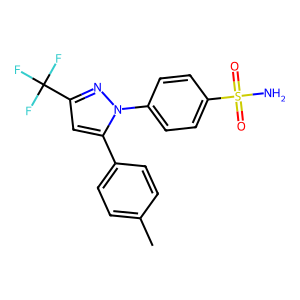

In [2]:
import safe as sf
import datamol as dm

celecoxib = "Cc1ccc(-c2cc(C(F)(F)F)nn2-c2ccc(S(N)(=O)=O)cc2)cc1"
celecoxib_mol = dm.to_mol(celecoxib)

display(dm.to_image(celecoxib_mol))


#### Encoding

**SAFE represents fragments**

SAFE represents molecules as a set of N [Fragment_1].[Fragment_i].[Fragment_N]
    

In [3]:
safe_str = sf.encode(celecoxib_mol)

print(safe_str)
print(f"Representation using {len(safe_str.split('.'))} fragments")


c14ccc(S(N)(=O)=O)cc1.Cc1ccc5cc1.c15cc3nn14.C3(F)(F)F
Representation using 4 fragments


**SAFE string are SMILES**

Any SAFE string is a valid SMILES and can be read by RDKit without any decoding trick.

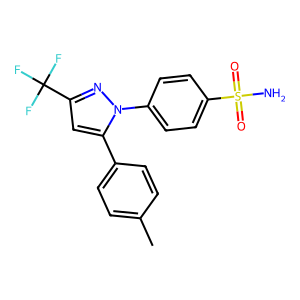

In [4]:
reconstructed = dm.to_mol(safe_str)

display(dm.to_image(reconstructed))

assert dm.same_mol(celecoxib_mol, reconstructed)


**SAFE supports randomization**

You can generate randomized SAFE strings.

In [5]:
random_safe_str = sf.encode(celecoxib_mol, canonical=False, randomize=True)

print(random_safe_str)

reconstructed = dm.to_mol(safe_str)

assert dm.same_mol(celecoxib_mol, reconstructed)


c15ccc(S(N)(=O)=O)cc1.c16cc4nn15.C4(F)(F)F.c16ccc(C)cc1


**Fragment order in SAFE does not matter**

Any permutation of the fragment order in a SAFE string preserve the molecule identity

In [6]:
import numpy as np

fragments = safe_str.split(".")
randomized_fragment_safe_str = np.random.permutation(fragments).tolist()
randomized_fragment_safe_str = ".".join(randomized_fragment_safe_str)

print(randomized_fragment_safe_str, safe_str)
assert dm.same_mol(celecoxib_mol, randomized_fragment_safe_str)


c14ccc(S(N)(=O)=O)cc1.c15cc3nn14.Cc1ccc5cc1.C3(F)(F)F c14ccc(S(N)(=O)=O)cc1.Cc1ccc5cc1.c15cc3nn14.C3(F)(F)F


**Use your own slicing logic**
    
By default SAFE strings are generated using `BRICS`, however, the following are supported:

* [Hussain-Rea (`hr`)](https://pubs.acs.org/doi/10.1021/ci900450m)
* [RECAP (`recap`)](https://pubmed.ncbi.nlm.nih.gov/9611787/)
* [RDKit's MMPA (`mmpa`)](https://www.rdkit.org/docs/source/rdkit.Chem.rdMMPA.html)
* Any possible attachment points (`attach`)
    
Furthermore, you can also provide your own slicing algorithm, which should return a pair of atoms corresponding to the bonds to break. 

In [7]:
def my_slicer(mol):
    """Slice on non single bonds where at both atoms are in a distinct rings"""
    for bond in mol.GetBonds():
        if bond.GetBondType() == dm.SINGLE_BOND and not bond.IsInRing() and (bond.GetBeginAtom().IsInRing() and bond.GetEndAtom().IsInRing()):
            yield (bond.GetBeginAtomIdx(), bond.GetEndAtomIdx())


In [9]:
safe_str = sf.encode(celecoxib_mol, canonical=True, slicer=my_slicer)
print(safe_str)
print(f"Representation using {len(safe_str.split('.'))} fragments")


c14cc(C(F)(F)F)nn13.c13ccc(S(N)(=O)=O)cc1.Cc1ccc4cc1
Representation using 3 fragments


Or simply use a SMARTS or a list of SMARTS.

In [11]:
# The above is equivalent to using the following SMARTS:
smart_slicer = ["[r]-;!@[r]"]
safe_str = sf.encode(celecoxib_mol, canonical=True, slicer=smart_slicer)
print(safe_str)
print(f"Representation using {len(safe_str.split('.'))} fragments")


c13cc(C(F)(F)F)nn14.c14ccc(S(N)(=O)=O)cc1.Cc1ccc3cc1
Representation using 3 fragments


#### Decoding

**Fragment order in SAFE does not matter**

Each `SAFE fragment` is a valid molecule itself, however, you need to use the decoder to recover molecules where all attachment point are not fullfiled.

In [13]:
safe_fragment = safe_str.split(".")
safe_fragment


['c13cc(C(F)(F)F)nn14', 'c14ccc(S(N)(=O)=O)cc1', 'Cc1ccc3cc1']

In [14]:
# the following will fail
dm.to_mol(safe_fragment[0])


[11:20:14] SMILES Parse Error: unclosed ring for input: 'c13cc(C(F)(F)F)nn14'


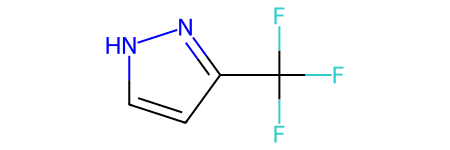

In [15]:
# while this works
sf.decode(safe_fragment[0], as_mol=True)


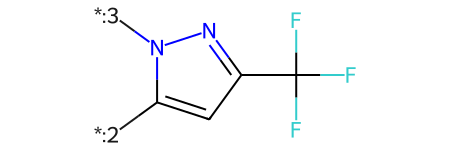

In [16]:
# if you want to keep the attachment points, then use remove_dummies=False
sf.decode(safe_fragment[0], as_mol=True, remove_dummies=False)


### Displaying a SAFE encoding

We provide a visualization module to display a safe string, with highlight of all the fragments that compose it.


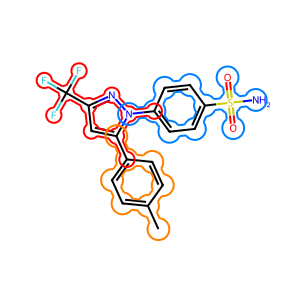

In [17]:
sf.to_image(safe_str)


There are 3 display modes for highlighting the fragments in a SAFE string. The difference between those modes is highlighted below using two different slicing algorithm. 

**Overlapping fragments**

Note that because some fragment might be matching overlapping substructure of the molecules (for example the same fragment appearing multiple time in the molecule), the highlighting might assigned the same color to these fragments.

In [18]:

from IPython.display import display
from ipywidgets import widgets, HBox

def display_image(safe_str):
    image_lasso = widgets.Image(value=sf.to_image(safe_str, highlight_mode="lasso", legend="lasso mode").data.encode(), format='svg+xml')
    image_fill = widgets.Image(value=sf.to_image(safe_str, highlight_mode="fill", legend="fill mode").data.encode(), format='svg+xml')
    image_color = widgets.Image(value=sf.to_image(safe_str, highlight_mode="color", legend="color mode").data.encode(), format='svg+xml')
    hbox = HBox([image_lasso, image_fill, image_color])
    display(hbox)


In [19]:
# display for brics
safe_str_brics = sf.encode(celecoxib_mol, canonical=True, slicer="brics")
display_image(safe_str_brics)


In [20]:
# display with HR
safe_str_hr = sf.encode(celecoxib_mol, canonical=True, slicer="mmpa")
display_image(safe_str_hr)


---

The End !